In [ ]:
#MATH 691Y - Project 
#sim_annealing.py
#Simulated annealing demo with TSP
#https://visualstudiomagazine.com/articles/2021/12/01/~/media/ECG/visualstudiomagazine/Images/2021/12/fig_1_tsp_annealing_demo_run.ashx 

In [ ]:
import numpy as np 
import random 
import networkx as nx 
import matplotlib.pyplot as plt 

rnd = np.random.RandomState(4) # random object for adjacent routes
num_loggers = 5
num_mills = 5

xcoord = [0,6.449176277857582, 2.34782915, 7.638949,3.682908, 8.25739, 8.210159364492801, 1.9591033904708433, 7.683727323272914, 4.437519279118743, 7.475798973242043,0]
ycoord = [0,5.169304535502429, 5.48392761, 5.428358, 3.947827, 7.273826, 7.400174360896942, 7.562614454164295, 1.0266328053710538, 2.0134066917963, 6.752904060405664,0]

# dist_mat = np.array([[58,40,42,19,41], [15,35,62,83,33], [35,54,74,102,52],[96,74,90,57,76]]) # distance from logger i to mill j
demand_mat = np.array([[1,0,3,0],[4,0,0,0],[0,9,0,0],[0,4,9,0]])

init_temp = 100
final_temp = 1
cooling = 0.9

In [ ]:
"""
Generate list of loggers. 
Odd number representation starting with 1

Parameters
----------
num_loggers : int
    number of loggers

Returns
-------
loggers: list
    logger locations
"""
def generate_loggers(num_loggers):
    loggers = list()
    for i in range(1,num_loggers*2,2):
        loggers.append(i)
    return loggers

"""
Generate list of mills. 
Even number representation starting with 2

Parameters
----------
num_mills : int
    number of mills

Returns
-------
mills: list
    mill locations
"""
def generate_mills(num_mills):
    mills = list()
    for i in range(2,num_mills*2+1,2):
        mills.append(i)
    return mills 

In [ ]:
"""
Read from a list of demands 

Parameters
----------
demands : list
    tuple list of demands from ((location A, location B), ...)

Returns
-------
mills: list
    mill locations
"""
def read_demands():
    return 0 



In [ ]:
"""
Generate random route starting and ending at hub. Imposes condition 
that route must go from logger --> mill. 

Parameters
----------
loggers: list
    list of all logger locations
mills: list
    list of all mill locations 
nlocations: int
    number of location pairs to visit 

Returns
-------
path: list
    a randomized truck route 
"""
def generate_rand_path(loggers,mills,nlocations):
    path = list()
   
    new_loggers = loggers.copy()
    new_mills = mills.copy()
    
    l = len(loggers)
    m = len(mills)
    
    if l < m:
        diff = m - l
        for i in range(diff):
            new_loggers.append(random.randrange(1,loggers[-1]+2,2))
    elif m < l:
        diff = l - m
        for i in range(diff):
            new_mills.append(random.randrange(2,mills[-1]+2,2))
        
    np.random.shuffle(new_loggers)
    np.random.shuffle(new_mills)
    
    new_loggers2 = new_loggers[:nlocations]
    new_mills2 = new_mills[:nlocations]
 
    # start and end at the hub 
    path.append(0)
    for i in range(len(new_loggers2)):
        path.append(new_loggers2[i])
        path.append(new_mills2[i])
            
    path.append(0)
    return path 

"""
Generate route for truck 2 which visits locations not already visited
by truck 1. Same constraints hold as in generate_rand_path() method.  

Parameters
----------
loggers: list
    list of all logger locations
mills: list
    list of all mill locations 
d: dictionary 
    availability dictionary that details which locations 
    have already been visited by truck 1  

Returns
-------
path: list
    a randomized truck route with remaining locations 
"""
def generate_path(loggers,mills,d):
    path = list()
    
    new_loggers = list()
    new_mills = list()
    
    l = len(loggers)
    m = len(mills)
    
    if l < m:
        diff = m - l
        for i in range(diff):
            new_loggers.append(random.randrange(1,loggers[-1]+2,2))
    elif m < l:
        diff = l - m
        for i in range(diff):
            new_mills.append(random.randrange(2,mills[-1]+2,2))
            
    for i in range(l):
        if d.get(loggers[i]) == 0:
            new_loggers.append(loggers[i])
        if d.get(mills[i]) == 0:
            new_mills.append(mills[i])
    
    np.random.shuffle(new_loggers)
    np.random.shuffle(new_mills)

    path.append(0)
    for i in range(len(new_loggers)):
        path.append(new_loggers[i])
        path.append(new_mills[i])
            
    path.append(0)
    return path 

def adjacent(route,rnd):
    n = len(route)
    
    parity = rnd.randint(0,2)
    first_loc = 0
    second_loc = 0

    while ( first_loc >= second_loc):
    
        if (parity == 0):
            first_loc = rnd.randint(1,n/2) * 2
            second_loc = rnd.randint(1,n/2) * 2
        else:
            first_loc = rnd.randint(1,n/2) * 2 - 1
            second_loc = rnd.randint(1,n/2) * 2 - 1

#     print("\nFirst loc",first_loc,"\nSecond loc",second_loc)
        
    new_path = list()
    
    temp = route[first_loc]
    
    for i in range(n):
        if i == first_loc:
            new_path.append(route[second_loc])
        elif i == second_loc:
            new_path.append(temp)
        else:        
            new_path.append(route[i])
        
    return new_path


In [ ]:
"""
Calculates the total distance of a given route  

Parameters
----------
route: list
   route of a singular truck 
xcoord: list
    x-coordinates of all locations in numerical order 
    0 (hub), 1 (logger), 2 (mill)... 0 (hub)
ycoord: list 
    y-coordinates of all locations in numerical order 
    0 (hub), 1 (logger), 2 (mill)... 0 (hub) 

Returns
-------
d: float 
    total distance of route  
"""
def total_dist(route,xcoord,ycoord):
    d = 0.0 
    for i in range(len(route)-1):
        d += np.sqrt ((ycoord[route[i]]-ycoord[route[i+1]])**2 + (xcoord[route[i]]-xcoord[route[i+1]])**2)
    return d

"""
Plots graph of a truck route  

Parameters
----------
route: list
   route of a singular truck 
xcoord: list
    x-coordinates of all locations in numerical order 
    0 (hub), 1 (logger), 2 (mill)... 0 (hub)
ycoord: list 
    y-coordinates of all locations in numerical order 
    0 (hub), 1 (logger), 2 (mill)... 0 (hub) 
     
"""
def plot_graph(route,xcoord,ycoord):
    locations = ["hub","logger1","mill2","logger3","mill4","logger5","mill6","logger7","mill8", "logger9","mill10","hub"]
    plt.scatter(xcoord,ycoord)
    for i, label in enumerate(locations):
        plt.annotate(label,(xcoord[i],ycoord[i]))
    
    xcoordnew = list()
    ycoordnew = list()
    
    for i in range(len(route)):
        xcoordnew.append(xcoord[route[i]])
        ycoordnew.append(ycoord[route[i]])

    plt.plot(xcoordnew,ycoordnew) 

In [34]:
def update_demand(route,locA,locB):
    n = 2*len(route)
    temp_demand_mat = np.ndarray.copy(demand_mat)
    for i in range(n-1):
        # path starting from logger
        if (i%2 == 0):
            temp_demand_mat[(route[i//2][locA])][(route[i//2][locB])] -= 1
        # path starting from mill
        else:
            temp_demand_mat[(route[(i+1)//2][locA])][(route[(i-1)//2][locB])] -= 1
    return temp_demand_mat

def find_overserved(route,demands):
    locA = list()
    locB = list()
    for i in range(len(demands)):
        for j in range(len(demands[0])):
            if (demands[i][j] < 0):
                locA.append(i)
                locB.append(j)
   
    return list(zip(locA,locB))

"""
Initializes dictionary that keeps track of number of visits to a particular location  

Parameters
----------
num_loggers: int
   number of loggers  
num_mills: int 
    number of mills  

Returns
-------
d: dictionary  
    (key: value) pairs represent (location: number of times visited)
    initializes all values to 0   
"""
def init_locations(num_loggers,num_mills):
    loggers = generate_loggers(num_loggers)
    mills = generate_mills(num_mills)
    d = {}
    
    d[0] = 0 #initalize hub to 0 visits 

    for i in loggers:
        d[i] = 0
    
    for i in mills:
        d[i] = 0
    
    return d

"""
Updates "times visited" dictionary from a route   

Parameters
----------
d: dictionary 
    "times visited" dictionary 
route: list
   route of a singular truck  
 
"""     
def update_availability(d,route):

    for i in range(len(route)):
        d[route[i]] += 1      

"""
Runs simulated annealing algorithm. Prints graphs of two truck routes and how they develop throughout 
the algorithm.    

Parameters
----------
max_iter: int 
    number of iterations per temperature step 
init_temp: int
   initial temperature 
xcoord: list
    x-coordinates of all locations in numerical order 
    0 (hub), 1 (logger), 2 (mill)... 0 (hub)
ycoord: list 
    y-coordinates of all locations in numerical order 
    0 (hub), 1 (logger), 2 (mill)... 0 (hub)
    
""" 
def solve(max_iter,init_temp,xcoord,ycoord):
    curr_temp = init_temp
    
    #Generate loggers and mills locations 
    loggers = generate_loggers(num_loggers)
    mills = generate_mills(num_mills)
    
    #Generate initial solution 
    truck1 = generate_rand_path(loggers,mills,3)
    times_visited_d = init_locations(num_loggers,num_mills)
    update_availability(times_visited_d,truck1)
    truck2 = generate_path(loggers,mills,times_visited_d)
    
    plot_graph(truck2,xcoord,ycoord)
    plot_graph(truck1,xcoord,ycoord)
    plt.show()
    
    truck1_dist  = total_dist(truck1,xcoord,ycoord) 
    truck2_dist = total_dist(truck2,xcoord,ycoord)
    print("Initial Truck1 route:", truck1, "Truck 1 distance:", truck1_dist)
    print("Initial Truck2 route:",truck2, "Truck 2 distance:", truck2_dist)
    print("Total distance:", truck1_dist + truck2_dist)

    while curr_temp > final_temp:
        
#         adj_sol = adjacent(fb_sol,rnd)
        truck1_adj_sol = generate_rand_path(loggers,mills,3)
        times_visited_d = init_locations(num_loggers,num_mills)
        update_availability(times_visited_d,truck1_adj_sol)
        truck2_adj_sol = generate_path(loggers,mills,times_visited_d)
        
        truck1_adj_dist = total_dist(truck1_adj_sol,xcoord,ycoord)
        truck2_adj_dist = total_dist(truck2_adj_sol,xcoord,ycoord)
#         truck1_dist = total_dist(truck1,xcoord,ycoord)
        
        if (truck1_adj_dist + truck2_adj_dist) < (truck1_dist + truck2_dist):
            truck1 = truck1_adj_sol
            truck2 = truck2_adj_sol
            plot_graph(truck1,xcoord,ycoord)
            plot_graph(truck2,xcoord,ycoord)
            plt.show()
            print("\nOld",truck1_dist,"-->New",truck1_adj_dist)
            print("\nOld",truck2_dist,"-->New",truck2_adj_dist)
            
        else:
            delta = ((truck1_adj_dist + truck2_adj_dist) - (truck1_dist + truck2_dist))
            if np.random.uniform(0,1) < ((curr_temp - delta)/curr_temp):
                truck1 = truck1_adj_sol
                truck2 = truck2_adj_sol
                plot_graph(truck1,xcoord,ycoord)
                plot_graph(truck2,xcoord,ycoord)

                plt.show()
                print("\nOld",truck1_dist,"-->New",truck1_adj_dist,"\nTemp threshold:",(curr_temp-delta)/curr_temp)
                print("\nOld",truck2_dist,"-->New",truck2_adj_dist,"\nTemp threshold:",(curr_temp-delta)/curr_temp)

        
        curr_temp = curr_temp * cooling 
        print("\nFinal route:", truck1, "\nTotal distance:",total_dist(truck1,xcoord,ycoord))
        print("\nFinal route:", truck2, "\nTotal distance:",total_dist(truck2,xcoord,ycoord))
        print("Total distance:",total_dist(truck1,xcoord,ycoord) + total_dist(truck2,xcoord,ycoord))

#         print("\nTruck2 new route:",adj_sol_truck2)
    

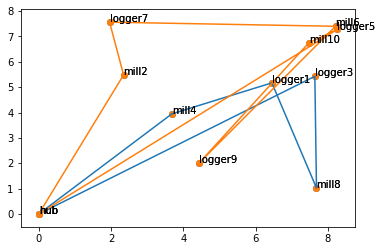

Initial Truck1 route: [0, 5, 10, 9, 6, 7, 2, 0] Truck 1 distance: 38.48299443721974
Initial Truck2 route: [0, 3, 8, 1, 4, 0] Truck 2 distance: 26.518871843028624
Total distance: 65.00186628024836


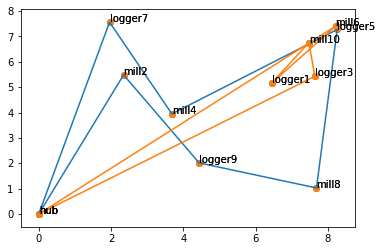


Old 38.48299443721974 -->New 37.15564584724664

Old 26.518871843028624 -->New 26.488255615028272

Final route: [0, 7, 4, 5, 8, 9, 2, 0] 
Total distance: 37.15564584724664

Final route: [0, 3, 10, 1, 6, 0] 
Total distance: 26.488255615028272
Total distance: 63.64390146227491


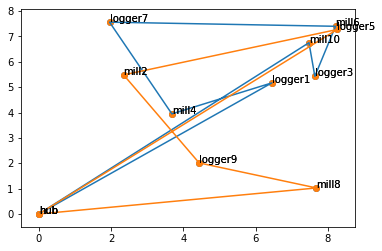


Old 38.48299443721974 -->New 35.00871727602683 
Temp threshold: 0.9735363589336122

Old 26.518871843028624 -->New 32.374876700196445 
Temp threshold: 0.9735363589336122

Final route: [0, 1, 4, 7, 6, 3, 10, 0] 
Total distance: 35.00871727602683

Final route: [0, 5, 2, 9, 8, 0] 
Total distance: 32.374876700196445
Total distance: 67.38359397622327


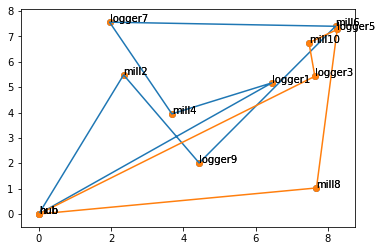


Old 38.48299443721974 -->New 38.140034540793444

Old 26.518871843028624 -->New 25.67058562891991

Final route: [0, 1, 4, 7, 6, 9, 2, 0] 
Total distance: 38.140034540793444

Final route: [0, 3, 10, 5, 8, 0] 
Total distance: 25.67058562891991
Total distance: 63.81062016971335


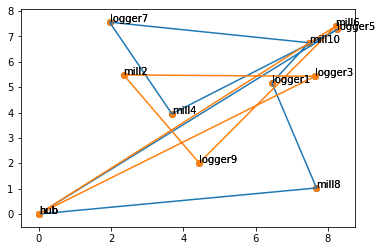


Old 38.48299443721974 -->New 40.20258680744217 
Temp threshold: 0.841646261560997

Old 26.518871843028624 -->New 36.343267005009515 
Temp threshold: 0.841646261560997

Final route: [0, 5, 4, 7, 10, 1, 8, 0] 
Total distance: 40.20258680744217

Final route: [0, 3, 2, 9, 6, 0] 
Total distance: 36.343267005009515
Total distance: 76.54585381245168


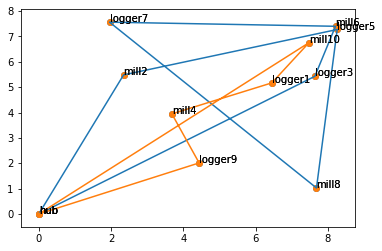


Old 38.48299443721974 -->New 44.779372280395734 
Temp threshold: 0.9739030962840284

Old 26.518871843028624 -->New 21.934711852657532 
Temp threshold: 0.9739030962840284

Final route: [0, 3, 6, 7, 8, 5, 2, 0] 
Total distance: 44.779372280395734

Final route: [0, 9, 4, 1, 10, 0] 
Total distance: 21.934711852657532
Total distance: 66.71408413305326


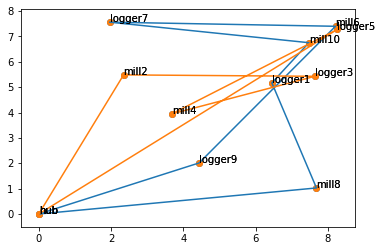


Old 38.48299443721974 -->New 37.240349597619215 
Temp threshold: 0.9258358771881553

Old 26.518871843028624 -->New 32.14083397054577 
Temp threshold: 0.9258358771881553

Final route: [0, 9, 6, 7, 10, 1, 8, 0] 
Total distance: 37.240349597619215

Final route: [0, 5, 4, 3, 2, 0] 
Total distance: 32.14083397054577
Total distance: 69.38118356816499


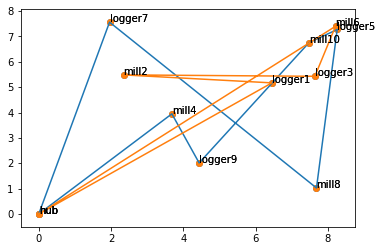


Old 38.48299443721974 -->New 36.81865515684568 
Temp threshold: 0.9512136063773322

Old 26.518871843028624 -->New 30.775920104725095 
Temp threshold: 0.9512136063773322

Final route: [0, 7, 8, 5, 10, 9, 4, 0] 
Total distance: 36.81865515684568

Final route: [0, 1, 2, 3, 6, 0] 
Total distance: 30.775920104725095
Total distance: 67.59457526157078


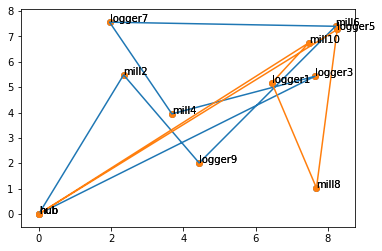


Old 38.48299443721974 -->New 40.44615757240485 
Temp threshold: 0.8117036603041221

Old 26.518871843028624 -->New 33.561864263632046 
Temp threshold: 0.8117036603041221

Final route: [0, 3, 4, 7, 6, 9, 2, 0] 
Total distance: 40.44615757240485

Final route: [0, 5, 8, 1, 10, 0] 
Total distance: 33.561864263632046
Total distance: 74.0080218360369


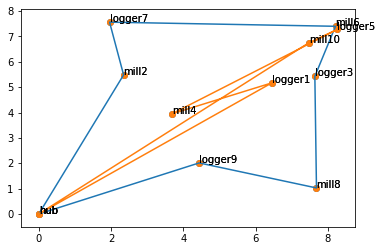


Old 38.48299443721974 -->New 29.053903909582324

Old 26.518871843028624 -->New 27.958423614475343

Final route: [0, 9, 8, 3, 6, 7, 2, 0] 
Total distance: 29.053903909582324

Final route: [0, 1, 4, 5, 10, 0] 
Total distance: 27.958423614475343
Total distance: 57.01232752405767


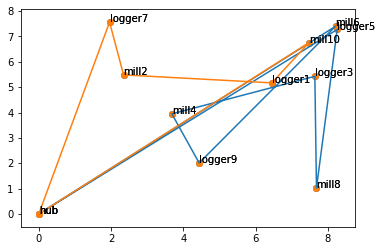


Old 38.48299443721974 -->New 45.60956176203997 
Temp threshold: 0.8293970195920235

Old 26.518871843028624 -->New 26.001813527659962 
Temp threshold: 0.8293970195920235

Final route: [0, 5, 8, 3, 4, 9, 6, 0] 
Total distance: 45.60956176203997

Final route: [0, 7, 2, 1, 10, 0] 
Total distance: 26.001813527659962
Total distance: 71.61137528969994

Final route: [0, 5, 8, 3, 4, 9, 6, 0] 
Total distance: 45.60956176203997

Final route: [0, 7, 2, 1, 10, 0] 
Total distance: 26.001813527659962
Total distance: 71.61137528969994


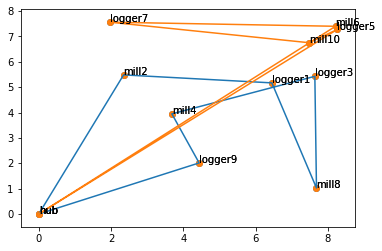


Old 38.48299443721974 -->New 29.97676941357146

Old 26.518871843028624 -->New 34.82549625174454

Final route: [0, 9, 4, 3, 8, 1, 2, 0] 
Total distance: 29.97676941357146

Final route: [0, 5, 10, 7, 6, 0] 
Total distance: 34.82549625174454
Total distance: 64.802265665316


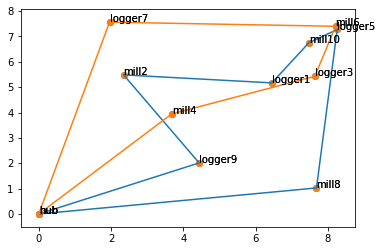


Old 38.48299443721974 -->New 29.889431344480585

Old 26.518871843028624 -->New 25.74130242767796

Final route: [0, 9, 2, 1, 10, 5, 8, 0] 
Total distance: 29.889431344480585

Final route: [0, 7, 6, 3, 4, 0] 
Total distance: 25.74130242767796
Total distance: 55.63073377215855

Final route: [0, 9, 2, 1, 10, 5, 8, 0] 
Total distance: 29.889431344480585

Final route: [0, 7, 6, 3, 4, 0] 
Total distance: 25.74130242767796
Total distance: 55.63073377215855


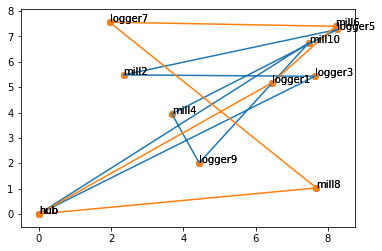


Old 38.48299443721974 -->New 44.27348734835104 
Temp threshold: 0.42856178615924456

Old 26.518871843028624 -->New 33.801052350765914 
Temp threshold: 0.42856178615924456

Final route: [0, 3, 2, 5, 4, 9, 10, 0] 
Total distance: 44.27348734835104

Final route: [0, 1, 6, 7, 8, 0] 
Total distance: 33.801052350765914
Total distance: 78.07453969911695


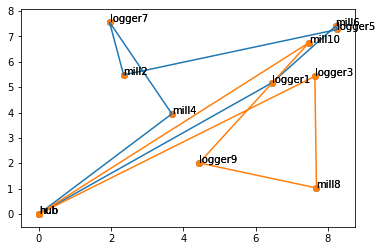


Old 38.48299443721974 -->New 28.935410528041437

Old 26.518871843028624 -->New 32.87002106244975

Final route: [0, 1, 6, 5, 2, 7, 4, 0] 
Total distance: 28.935410528041437

Final route: [0, 3, 8, 9, 10, 0] 
Total distance: 32.87002106244975
Total distance: 61.80543159049119

Final route: [0, 1, 6, 5, 2, 7, 4, 0] 
Total distance: 28.935410528041437

Final route: [0, 3, 8, 9, 10, 0] 
Total distance: 32.87002106244975
Total distance: 61.80543159049119


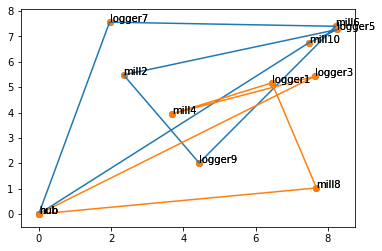


Old 38.48299443721974 -->New 41.88112782462062 
Temp threshold: 0.6658187934261228

Old 26.518871843028624 -->New 28.693939158274112 
Temp threshold: 0.6658187934261228

Final route: [0, 7, 6, 9, 2, 5, 10, 0] 
Total distance: 41.88112782462062

Final route: [0, 3, 4, 1, 8, 0] 
Total distance: 28.693939158274112
Total distance: 70.57506698289473


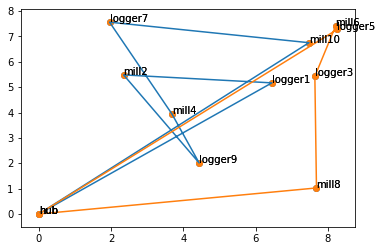


Old 38.48299443721974 -->New 38.160846404725376

Old 26.518871843028624 -->New 25.345963314897404

Final route: [0, 1, 2, 9, 4, 7, 10, 0] 
Total distance: 38.160846404725376

Final route: [0, 5, 6, 3, 8, 0] 
Total distance: 25.345963314897404
Total distance: 63.50680971962278


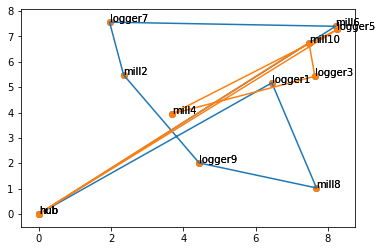


Old 38.48299443721974 -->New 39.45278775648834 
Temp threshold: 0.5007809940214876

Old 26.518871843028624 -->New 32.292787040970794 
Temp threshold: 0.5007809940214876

Final route: [0, 1, 8, 9, 2, 7, 6, 0] 
Total distance: 39.45278775648834

Final route: [0, 5, 4, 3, 10, 0] 
Total distance: 32.292787040970794
Total distance: 71.74557479745914


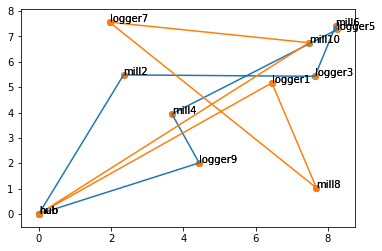


Old 38.48299443721974 -->New 26.049692298196753

Old 26.518871843028624 -->New 36.92642603806561

Final route: [0, 9, 4, 5, 6, 3, 2, 0] 
Total distance: 26.049692298196753

Final route: [0, 1, 8, 7, 10, 0] 
Total distance: 36.92642603806561
Total distance: 62.97611833626236


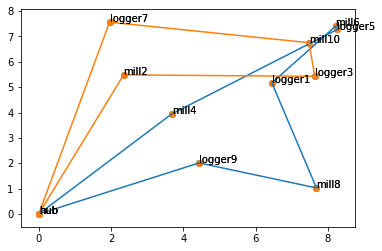


Old 38.48299443721974 -->New 26.62035390565789

Old 26.518871843028624 -->New 25.9793979486221

Final route: [0, 9, 8, 1, 6, 5, 4, 0] 
Total distance: 26.62035390565789

Final route: [0, 7, 10, 3, 2, 0] 
Total distance: 25.9793979486221
Total distance: 52.59975185427999


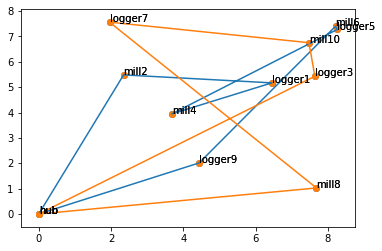


Old 38.48299443721974 -->New 30.342820735792678

Old 26.518871843028624 -->New 32.72215135942983

Final route: [0, 9, 6, 5, 4, 1, 2, 0] 
Total distance: 30.342820735792678

Final route: [0, 3, 10, 7, 8, 0] 
Total distance: 32.72215135942983
Total distance: 63.06497209522251


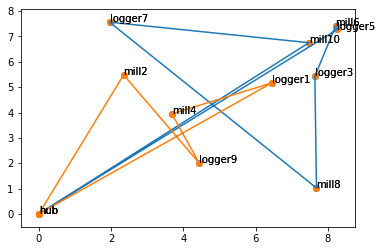


Old 38.48299443721974 -->New 41.93246461250037 
Temp threshold: 0.9647281314974359

Old 26.518871843028624 -->New 23.382014055650735 
Temp threshold: 0.9647281314974359

Final route: [0, 5, 6, 3, 8, 7, 10, 0] 
Total distance: 41.93246461250037

Final route: [0, 1, 4, 9, 2, 0] 
Total distance: 23.382014055650735
Total distance: 65.31447866815111


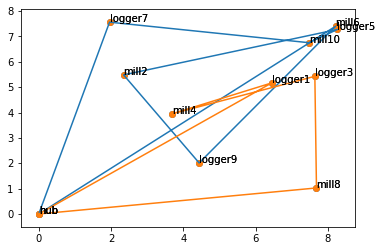


Old 38.48299443721974 -->New 42.18259611990427 
Temp threshold: 0.3922447851590862

Old 26.518871843028624 -->New 27.667117335272117 
Temp threshold: 0.3922447851590862

Final route: [0, 7, 10, 5, 2, 9, 6, 0] 
Total distance: 42.18259611990427

Final route: [0, 1, 4, 3, 8, 0] 
Total distance: 27.667117335272117
Total distance: 69.84971345517638

Final route: [0, 7, 10, 5, 2, 9, 6, 0] 
Total distance: 42.18259611990427

Final route: [0, 1, 4, 3, 8, 0] 
Total distance: 27.667117335272117
Total distance: 69.84971345517638

Final route: [0, 7, 10, 5, 2, 9, 6, 0] 
Total distance: 42.18259611990427

Final route: [0, 1, 4, 3, 8, 0] 
Total distance: 27.667117335272117
Total distance: 69.84971345517638


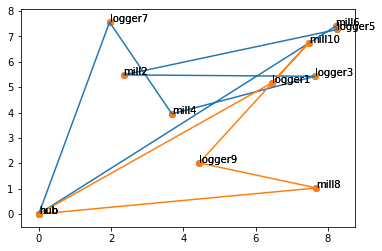


Old 38.48299443721974 -->New 38.69502500227232 
Temp threshold: 0.893337039073055

Old 26.518871843028624 -->New 26.92708359056278 
Temp threshold: 0.893337039073055

Final route: [0, 7, 4, 3, 2, 5, 6, 0] 
Total distance: 38.69502500227232

Final route: [0, 1, 10, 9, 8, 0] 
Total distance: 26.92708359056278
Total distance: 65.6221085928351

Final route: [0, 7, 4, 3, 2, 5, 6, 0] 
Total distance: 38.69502500227232

Final route: [0, 1, 10, 9, 8, 0] 
Total distance: 26.92708359056278
Total distance: 65.6221085928351


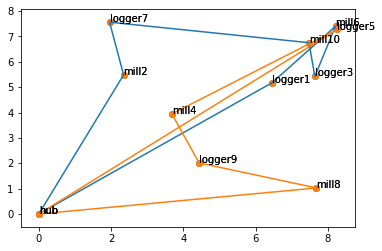


Old 38.48299443721974 -->New 28.150703056496546

Old 26.518871843028624 -->New 29.881313271232656

Final route: [0, 1, 6, 3, 10, 7, 2, 0] 
Total distance: 28.150703056496546

Final route: [0, 5, 4, 9, 8, 0] 
Total distance: 29.881313271232656
Total distance: 58.0320163277292

Final route: [0, 1, 6, 3, 10, 7, 2, 0] 
Total distance: 28.150703056496546

Final route: [0, 5, 4, 9, 8, 0] 
Total distance: 29.881313271232656
Total distance: 58.0320163277292

Final route: [0, 1, 6, 3, 10, 7, 2, 0] 
Total distance: 28.150703056496546

Final route: [0, 5, 4, 9, 8, 0] 
Total distance: 29.881313271232656
Total distance: 58.0320163277292


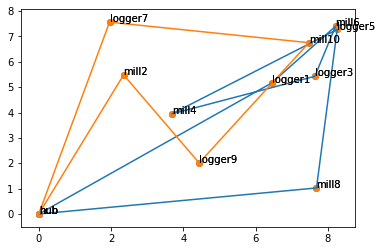


Old 38.48299443721974 -->New 37.06554314030559 
Temp threshold: 0.6802453643459759

Old 26.518871843028624 -->New 29.034259458851523 
Temp threshold: 0.6802453643459759

Final route: [0, 1, 6, 3, 4, 5, 8, 0] 
Total distance: 37.06554314030559

Final route: [0, 7, 10, 9, 2, 0] 
Total distance: 29.034259458851523
Total distance: 66.09980259915712


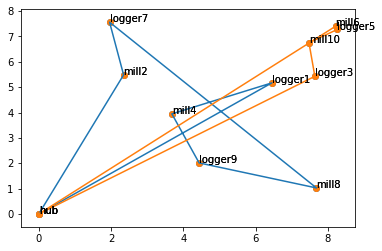


Old 38.48299443721974 -->New 33.527039766472754

Old 26.518871843028624 -->New 22.833009588852093

Final route: [0, 1, 4, 9, 8, 7, 2, 0] 
Total distance: 33.527039766472754

Final route: [0, 3, 10, 5, 6, 0] 
Total distance: 22.833009588852093
Total distance: 56.36004935532485


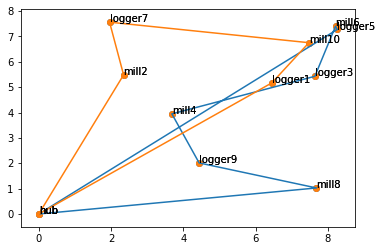


Old 38.48299443721974 -->New 30.63728630704876

Old 26.518871843028624 -->New 23.80836415015228

Final route: [0, 5, 6, 3, 4, 9, 8, 0] 
Total distance: 30.63728630704876

Final route: [0, 1, 10, 7, 2, 0] 
Total distance: 23.80836415015228
Total distance: 54.44565045720104

Final route: [0, 5, 6, 3, 4, 9, 8, 0] 
Total distance: 30.63728630704876

Final route: [0, 1, 10, 7, 2, 0] 
Total distance: 23.80836415015228
Total distance: 54.44565045720104


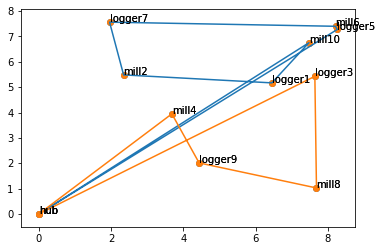


Old 38.48299443721974 -->New 35.581846965228834

Old 26.518871843028624 -->New 24.641482683089258

Final route: [0, 5, 6, 7, 2, 1, 10, 0] 
Total distance: 35.581846965228834

Final route: [0, 3, 8, 9, 4, 0] 
Total distance: 24.641482683089258
Total distance: 60.22332964831809


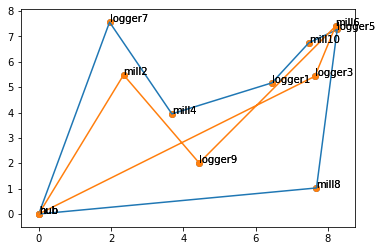


Old 38.48299443721974 -->New 31.692986875057507

Old 26.518871843028624 -->New 28.017099726993294

Final route: [0, 7, 4, 1, 10, 5, 8, 0] 
Total distance: 31.692986875057507

Final route: [0, 3, 6, 9, 2, 0] 
Total distance: 28.017099726993294
Total distance: 59.7100866020508

Final route: [0, 7, 4, 1, 10, 5, 8, 0] 
Total distance: 31.692986875057507

Final route: [0, 3, 6, 9, 2, 0] 
Total distance: 28.017099726993294
Total distance: 59.7100866020508


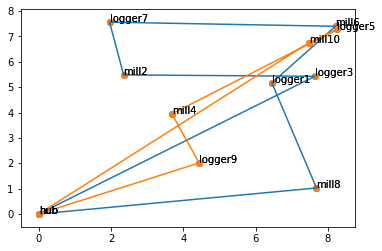


Old 38.48299443721974 -->New 37.94744046104175

Old 26.518871843028624 -->New 23.618594201090488

Final route: [0, 3, 2, 7, 6, 1, 8, 0] 
Total distance: 37.94744046104175

Final route: [0, 9, 4, 5, 10, 0] 
Total distance: 23.618594201090488
Total distance: 61.56603466213224


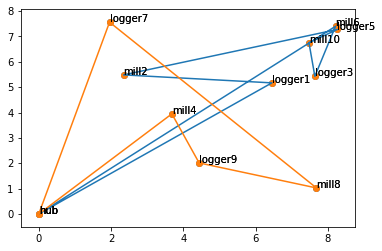


Old 38.48299443721974 -->New 33.93302096778894

Old 26.518871843028624 -->New 27.369032520003092

Final route: [0, 1, 2, 5, 10, 3, 6, 0] 
Total distance: 33.93302096778894

Final route: [0, 7, 8, 9, 4, 0] 
Total distance: 27.369032520003092
Total distance: 61.30205348779204

Final route: [0, 1, 2, 5, 10, 3, 6, 0] 
Total distance: 33.93302096778894

Final route: [0, 7, 8, 9, 4, 0] 
Total distance: 27.369032520003092
Total distance: 61.30205348779204


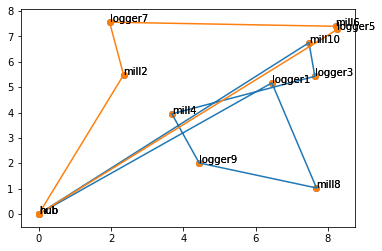


Old 38.48299443721974 -->New 33.689937036813994

Old 26.518871843028624 -->New 25.47238359891898

Final route: [0, 1, 8, 9, 4, 3, 10, 0] 
Total distance: 33.689937036813994

Final route: [0, 5, 6, 7, 2, 0] 
Total distance: 25.47238359891898
Total distance: 59.162320635732975


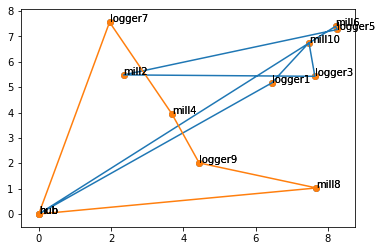


Old 38.48299443721974 -->New 34.14101611802865

Old 26.518871843028624 -->New 25.038297354191307

Final route: [0, 1, 10, 3, 2, 5, 6, 0] 
Total distance: 34.14101611802865

Final route: [0, 7, 4, 9, 8, 0] 
Total distance: 25.038297354191307
Total distance: 59.17931347221996


In [35]:
def main():
    solve(4,init_temp,xcoord,ycoord)
    
    
# route = [0, 3, 4, 5, 6, 1, 2, 0]
# loggers = generate_loggers(num_loggers)
# mills = generate_mills(num_mills)
# d = availability(route)

# route = generate_rand_path(loggers,mills)
# new_route = generate_path(loggers,mills)
# print(route)
# print(new_route)

main()


In [ ]:
"""
# loggers1 = generate_loggers(3)
# mills1 = generate_mills(3) 
# truck1 = generate_rand_path(loggers1,mills1)

# loggers2 = generate_loggers(2)
# mills2 = generate_mills(2)
# truck2 = generate_rand_path(loggers2,mills2)

# plot_graph(truck1,xcoord,ycoord)
# print(truck1)
# plot_graph(truck2,xcoord,ycoord)
# print(truck2)

# main()

# plot_graph()

# xcoord = []
# # for i in range(10):
# #     n = random.uniform(0,10)
# #     xcoord.append(n)
# # ycoord = []
# # for i in range(0,10):
# #     n = random.uniform(0,10)
# #     ycoord.append(n)
# xcoord = [0,6.449176277857582, 8.210159364492801, 1.9591033904708433,7.683727323272914, 4.437519279118743, 7.475798973242043]
# ycoord = [0,5.169304535502429, 7.400174360896942, 7.562614454164295, 1.0266328053710538, 2.0134066917963, 6.752904060405664]

# dist_mat = np.linspace(0,1,num=16).reshape(4,4)
# for i in range(len(xcoord)//2):
#     for j in range(len(xcoord)//2):
#         dist_mat[i][j] = np.sqrt((ycoord[i]-ycoord[j+4])**2 + (xcoord[i]-xcoord[j+4])**2)
        
# print(dist_mat)
# route = [0, 5, 4, 3, 6, 1, 2, 0] 
# xcoord = [0,6.449176277857582, 8.210159364492801, 1.9591033904708433, 7.683727323272914, 4.437519279118743, 7.475798973242043,0]
# ycoord = [0,5.169304535502429, 7.400174360896942, 7.562614454164295, 1.0266328053710538, 2.0134066917963, 6.752904060405664,0]
# locations = ["hub","logger1","mill2","logger3","mill4","logger5","mill6","hub"]

# plt.scatter(xcoord,ycoord)
# for i, label in enumerate(locations):
#     plt.annotate(label,(xcoord[i],ycoord[i]))
        
# xcoordnew = list()
# ycoordnew = list()
# for i in range(len(route)):
#     xcoordnew.append(xcoord[route[i]])
#     ycoordnew.append(ycoord[route[i]])

# plt.plot(xcoordnew,ycoordnew) 

# plt.show()


            
# plt.scatter(xcoord,ycoord)
# for i, label in enumerate(locations):
#     plt.annotate(label,(xcoord[i],ycoord[i]))
    
# plt.plot(xcoordn2,ycoordn2)
# print(xcoordn2,ycoordn2)
# print(adj_sol)
# print(total_dist(adj_sol,0,1))
# plt.show


# new_sol = [(0,0),(2,2),(1,2)] #244 miles 
# print(demand_mat)
# updated_demand_mat = update_demand(init_sol,0,1)
# print(updated_demand_mat)

# print(find_overserved(init_sol,updated_demand_mat))

# xcoord = [0,6.449176277857582, 8.210159364492801, 1.9591033904708433,7.683727323272914, 4.437519279118743, 7.475798973242043,0]
# ycoord = [0,5.169304535502429, 7.400174360896942, 7.562614454164295, 1.0266328053710538, 2.0134066917963, 6.752904060405664,0]

# loggers = generate_loggers(3)
# mills = generate_mills(3)
# print(loggers,mills)

# path = generate_rand_path(loggers,mills)
# print(path)
# new_path = adjacent(path,rnd)
# print(new_path)

#d = total_dist(new_path,xcoord,ycoord)
# print(d)

# solve(4,init_temp,xcoord,ycoord
"""